In [1]:
import os
import pandas as pd
import matplotlib
import math
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)


__location__ = os.path.realpath((os.getcwd()))

raw_data = pd.read_csv(os.path.join(__location__, 'data/cleaned_data.csv'))
raw_data['date_time']  = pd.to_datetime(raw_data['date_time'])

user_messages = raw_data[raw_data['user']!='WhatsApp']
notifications = raw_data[raw_data['user']=='WhatsApp']

print 'loaded',len(user_messages),'user messages and',len(notifications),'WhatsApp notifications from file'

user_names = set(user_messages['user'])
min_day = raw_data['date_time'].min()
max_day = raw_data['date_time'].max()

loaded 17056 user messages and 125 WhatsApp notifications from file


/home/mikesj/new_env/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


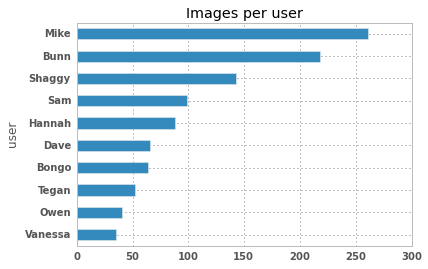

In [2]:
user_messages['image_count']= [string.count('[MEDIA]') for string in user_messages.message]
grouped_by_user = user_messages.groupby(['user'],as_index = False)
images_by_user = grouped_by_user.agg({'image_count' : np.sum})
images_by_user.sort(columns = 'image_count',inplace=True)

plt.figure(figsize=(10,10))
images_by_user[-10:].plot(x='user',y='image_count',kind = 'barh', legend = False, title = 'Images per user')
plt.show()

In [3]:
from pandas import DataFrame
from pylab import *
import csv

emoji_dict = {}
count = 0

for row in user_messages.iterrows():
    date_time = row[1].get_value('date_time')
    user = row[1].get_value('user')
    emoji_str = str(row[1].get_value('emoji'))
    
    if emoji_str == 'nan':
        continue
    for emoji in emoji_str.split(","):
        new_dict = {'date_time':date_time,
                    'user':user,
                    'emoji_code':emoji
                    }
        emoji_dict[count] = new_dict
        count+=1
emoji_timestamps=DataFrame.from_dict(emoji_dict, orient = 'index')
output_path = os.path.join(__location__, 'data/emoji_data.csv')
emoji_timestamps.to_csv(output_path, index = False, quoting = csv.QUOTE_ALL)


user_messages['contains_emoji']=[str(emoji) != 'nan' for emoji in user_messages.emoji.values]
user_emoji_count = user_messages.groupby(['user'],as_index = False) 
emoji_count = user_emoji_count.agg({"contains_emoji" : np.sum})

/home/mikesj/new_env/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
num_emojis=16
num_users=10

# first we find the top emojis
grouped_by_emoji = emoji_timestamps.groupby(['emoji_code'],as_index = False)
emoji_counts= grouped_by_emoji['user'].agg({"count" : pd.Series.count})
emoji_counts.sort(columns = 'count',inplace=True, ascending=False)
top_emojis=emoji_counts.emoji_code[0:num_emojis]

# drill down to these emojis
emoji_timestamps_ = emoji_timestamps[emoji_timestamps.emoji_code.isin(top_emojis)]

# find the top users for these emojis
grouped_by_user = emoji_timestamps_.groupby(['user'],as_index = False)
user_counts= grouped_by_user['user'].agg({"count" : pd.Series.count})
user_counts.sort(columns = 'count',inplace=True, ascending=False)
top_users = user_counts.user[0:num_users].values

# convert the names to 'Other' if not in top_users
def convert_name(name):
    if name in top_users:
        return name
    else:
        return "Other"
emoji_timestamps_['user'] = [convert_name(name) for name in emoji_timestamps_.user]

/home/mikesj/new_env/lib/python2.7/site-packages/IPython/kernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
grouped_by_user_emoji = emoji_timestamps_.groupby(['user','emoji_code'])
emoji_user_counts= grouped_by_user_emoji.size().reset_index()  \
    .pivot(index='emoji_code', columns='user', values=0).reset_index('emoji_code').fillna(0)
    
emoji_user_counts=pd.merge(emoji_user_counts,emoji_counts,on = 'emoji_code') \
            .sort('count', ascending = False)
unicodes = emoji_user_counts[:num_emojis]['emoji_code'].values
print emoji_user_counts
emoji_user_counts = emoji_user_counts.drop(['emoji_code','count'], 1)
print emoji_user_counts

   emoji_code  Bunn  Hannah  Joe  Krizia  Other  Owen  Sam  Shaggy  Tanya  \
6       1f389    13      13   27     213     28     8    2      37      0   
8       1f3b7     0      87    0       0      0   168    0       0      0   
9       1f3ba     0      88    0       0      0   121    0       0      0   
7       1f38a     1       3   21      31      1     4    7       1     25   
0       1f1fd     0       0   15      92      2     2    0       0      0   
13      1f60d     0       1    2      60      4     1    1       1      0   
10      1f44d    24       1   15       2     10     5    6       0      0   
2       1f354     0      60    0       0      1     0    1       0      0   
14      1f61d     1       0   28       6      1     2    0       0      1   
3       1f35f     0      34    0       0      1     1    0       0      0   
4       1f37b    15       0    0       4     10     1    2       0      0   
11      1f46f     0       0    0      14     10    10    0       0      0   

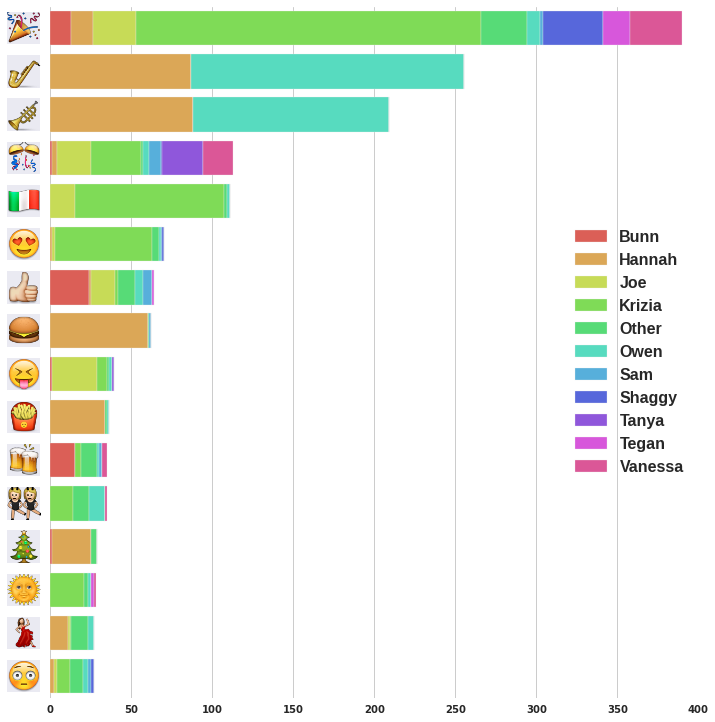

In [6]:
import seaborn as sns

#emoji_user_counts.sort(columns = 'count',inplace=True, ascending=False)
names = emoji_user_counts.columns.values
data =  emoji_user_counts.values
lefts = np.cumsum(data, axis=1)

colors = sns.color_palette("hls", num_users + 1)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(frameon=True)
ax.set_axis_bgcolor((1, 1, 1))
grid(b=True, which='major', color='#cccccc', linestyle='-')
pos = (arange(num_emojis)+.5)[::-1]
val = emoji_counts[:num_emojis]['count'].values
#unicodes = emoji_counts[:num_emojis]['emoji_code'].values

plt.barh(pos, data[:,0], color=colors[0],align='center',label= names[0])
for j in xrange(1,data.shape[1]):
    plt.barh(pos, data[:,j], color=colors[j], left=lefts[:,j-1],align='center', label= names[j])
ax.yaxis.set_visible(False)

ax.grid(True)
subplots_adjust(bottom=0.0,top= 0.1 * num_emojis,left = 0, right = 1.5)
plt.legend(loc = 7,prop={'size':16})
import matplotlib.image as mpimg

def get_image_name(unicode_str):
    return "emoji/images/" + unicode_str + ".png"

def get_image_limits(pos_idx):
    height = (num_emojis - 1.0 - pos_idx) / 10 + (0.0125)
    return [-0.1,height,0.075,0.075]

for idx in range(num_emojis):
    unicode_str = unicodes[idx]
    try: 
        im = mpimg.imread(get_image_name(unicode_str))
        axicon = fig.add_axes(get_image_limits(idx))
        axicon.imshow(im)
        axicon.set_xticks([])
        axicon.set_yticks([])    
    except IOError:
        print 'could not find image for file ', get_image_name(unicode_str) 
        
    
    
savefig(os.path.join(__location__, 'data/emoticons_plot.png'), bbox_inches='tight')
